# Task 1: Acquire the data

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot
import random
import warnings
warnings.filterwarnings('ignore')
#from keras.datasets import mnist

# Load the dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
# Use the Fashion-MNIST dataset with the default train and test partitions
(train_x,train_y), (test_x,test_y) = fashion_mnist.load_data()

temp_train_x = np.copy(train_x)
temp_test_x = np.copy(test_x)
temp_train_x = temp_train_x.astype('float64')
temp_test_x = temp_test_x.astype('float64')

# Data processing
# Mean subtraction
temp_train_x -= np.mean(temp_train_x, axis=0)
temp_test_x -= np.mean(temp_test_x, axis=0)
# Normalization
temp_train_x /= np.std(temp_train_x, axis=0)
temp_test_x /= np.std(temp_test_x, axis=0)

#for normalized data
train_tuple = (temp_train_x, train_y)
test_tuple = (temp_test_x, test_y)
#for unnormalized data
train_tuple1 = (train_x, train_y)
test_tuple1 = (test_x, test_y)

# Vectorize data to have the appropriate dimensions
def vectorized_result(y):
    e = np.zeros((10, 1))
    e[y] = 1.0
    return e

train_data = []
test_data = []
training_inputs = [np.reshape(x, (784,1)) for x in train_tuple[0]]
training_results = [vectorized_result(y) for y in train_tuple[1]]
for i in range(len(training_results)):
    t = (training_inputs[i], training_results[i])
    train_data.append(t)

test_inputs = [np.reshape(x, (784,1)) for x in test_tuple[0]]
for i in range(len(test_tuple[1])):
    t = (test_inputs[i], test_tuple[1][i])
    test_data.append(t)

unnorm_train_data = []
unnorm_test_data = []
training_inputs = [np.reshape(x, (784,1)) for x in train_tuple1[0]]
training_results = [vectorized_result(y) for y in train_tuple1[1]]
for i in range(len(training_results)):
    t = (training_inputs[i], training_results[i])
    unnorm_train_data.append(t)

test_inputs = [np.reshape(x, (784,1)) for x in test_tuple1[0]]
for i in range(len(test_tuple[1])):
    t = (test_inputs[i], test_tuple[1][i])
    unnorm_test_data.append(t)


plot of class distribution

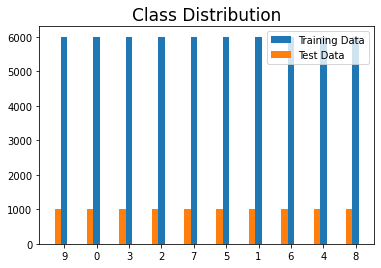

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
sorted_list = sorted(train_y)
sorted_counted = Counter(train_y)
sorted_list1 = sorted(test_y)
sorted_counted1 = Counter(test_y)
X = np.arange(len(sorted_counted1))
ax = plt.subplot(111)
ax.bar(X, sorted_counted.values(), width=0.2, align='center')
ax.bar(X-0.2, sorted_counted1.values(), width=0.2, align='center')
ax.legend(('Training Data','Test Data'))
plt.xticks(X, sorted_counted.keys())
plt.title("Class Distribution", fontsize=17)
plt.show()

# Task 2: Implement a Multilayer Perceptron

In [ ]:
def sigmoid():
    """The sigmoid function."""
    return lambda z: 1.0/(1.0+np.exp(-z))

def sigmoid_prime():
    """Derivative of the sigmoid function."""
    act=sigmoid()
    return lambda z: (act(z))*(1-(act(z)))

def softmax():
    """The sigmoid function."""
    return lambda z: 1.0/(1.0+np.exp(-z))

def softmax_prime():
    act=softmax()
    return lambda z: (act(z))*(1-(act(z)))

def ReLU():
    return lambda z: z*(z>0)

def ReLU_prime():
    return lambda z: 1.0*(z>0)

def tanh():
    return lambda z: np.tanh(z)

def tanh_prime():
    return lambda z: (1-np.tanh(z)**2)

def Leaky_ReLU(alpha=0.01):
    return lambda z: ((z > 0) * z)+((z <= 0) * z * alpha)  

def Leaky_ReLU_prime(alpha=0.01):
    return lambda z: ((z > 0) * 1)+((z <= 0) * 1 * alpha) 

class MLP():
    def __init__(self, function=softmax(), function_prime=softmax_prime(), num_hidden_layers=0, hidden_units_list=[], dropout_rate=1):
        self.function = function
        self.function_prime = function_prime
        self.num_layers = num_hidden_layers + 2
        self.dropout_rate=dropout_rate
        for i in range(len(hidden_units_list)):
            hidden_units_list[i]=int(hidden_units_list[i]*self.dropout_rate)
        units_list = [int(784*dropout_rate)] + hidden_units_list + [10]
        self.units_list = units_list
        # generates biases randomly, using Gaussian distribution with mean 0 and standard deviation 1
        self.biases = [np.random.randn(y, 1) for y in units_list[1:]]
        # net.weights[1] is a numpy Matrix storing the weights connecting the second and third layers of neurons(units)
        # net.weights[1] has a weight matrix: Wjk 
        # Wjk is the weight for the connection between the kth neuron in the second layer and jth neuron in the third layer
        self.weights = [np.random.randn(y, x)*int(1/self.dropout_rate) for x, y in zip(units_list[:-1], units_list[1:])]

    def feedforward(self, a):
        # return the network of the output if a is the input
        # get the activation values for the next layer
        for b, w in zip(self.biases, self.weights):
            a = self.function(np.dot(w, a)+b)
        return a

    # training_data: list of tuples (x, y) where x is the 784 pixels and y is the corresponding class
    def fit(self, training_data, epochs, mini_batch_size, learning_rate):
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, learning_rate)
        return self
            
    def update_mini_batch(self, mini_batch, learning_rate):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            temp_x=np.random.choice(np.reshape(x, x.shape[0]), int(x.shape[0]*self.dropout_rate), replace=False)
            temp_x=temp_x.reshape((temp_x.shape[0], 1))
            delta_nabla_b, delta_nabla_w = self.backprop(temp_x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(learning_rate)*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(learning_rate)*nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward part
        activation =x
        activations = [x] # list to store all the activation values, layer by layer
        z_vectors = [] # list to store all z vectors, layer by layer
        
        # the last layer is using the softmax function
        if self.num_layers == 2:
            for b, w in zip(self.biases, self.weights):
                z = np.dot(w, activation) + b
                z_vectors.append(z)
                activations.append(self.function(z))

        elif self.num_layers == 3:
            # from the first layer to the second using the given input function
            z = np.dot(self.weights[0], activation) + self.biases[0]
            z_vectors.append(z)
            activation = self.function(z)
            activations.append(activation)

            # from the second layer to the third layer using softmax function
            z = np.dot(self.weights[1], activation) + self.biases[1]
            z_vectors.append(z)
            act=softmax()
            activation = act(z)
            activations.append(activation)
        
        else:
            for b, w in zip(self.biases[:-1], self.weights[:-1]):                
                z = np.dot(w, activation) + b
                z_vectors.append(z)
                activation = self.function(z)
                activations.append(activation)
            
            # from the second last layer to the final layer using softmax function
            z = np.dot(self.weights[-1], activation) + self.biases[-1]
            z_vectors.append(z)
            act=softmax()
            activation = act(z)
            activations.append(activation)

        # backward pass
        act=softmax_prime()
        delta = self.cost_derivative(activations[-1], y) * act(z_vectors[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for layer in range(2, self.num_layers):
            z = z_vectors[-layer]
            vector_prime = self.function_prime(z)
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * vector_prime
            nabla_b[-layer] = delta
            nabla_w[-layer] = np.dot(delta, activations[-layer-1].transpose())
        return (nabla_b, nabla_w)

    def predict(self, test_data):
        n_test = len(test_data)
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return test_results
        #print(f"Epoch {j}, the accuracy is :{evaluate_acc(test_results, test_data)}")
        
    def cost_derivative(self, output_activations, y):
        return(output_activations - y)
    
def evaluate_acc(test_results, test_data):
    return sum(int(x == y) for (x, y) in test_results)/len(test_data)

# Task 3: Run the experiments

Experiment #1 (an MLP with no hidden layers)

In [ ]:
model = MLP()
model.fit(train_data, epochs=90, mini_batch_size=750, learning_rate=0.003)
pred=model.predict(test_data)
acc = evaluate_acc(pred, test_data)
print(f"The test accuracy for an MLP with no hidden layers is :{acc}")

The test accuracy for an MLP with no hidden layers is :0.8130


find best learning rate 

0.001
0.7473
0.003
0.7503
0.005
0.7406
0.007
0.686
0.009
0.6595
0.01
0.651
0.02
0.5753


Text(0, 0.5, 'Accuracy')

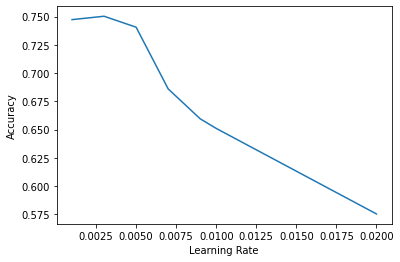

In [ ]:
import matplotlib.pyplot as plt
learning_rate=[0.001,0.003,0.005,0.007,0.009,0.01,0.02,0.03,0.04,0.05]
acc=[]
for i in learning_rate:
    print(i)
    model = MLP()
    model.fit(train_data, epochs=20, mini_batch_size=1000, learning_rate=i)
    pred=model.predict(test_data)
    accuracy=evaluate_acc(pred, test_data)
    acc.append(accuracy)
    print(accuracy)
plt.plot(learning_rate,acc, label='accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

100
0.3486
200
0.3568
300
0.3394
400
0.5021
500
0.5263
600
0.4754
700
0.5133
800
0.5411
900
0.4943
1000
0.4689


Text(0, 0.5, 'Accuracy')

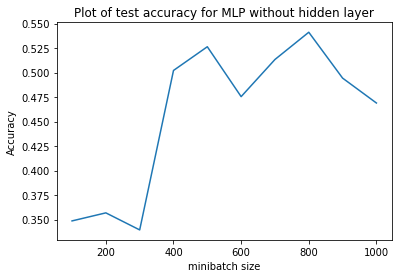

In [ ]:
#find best minibatch_size for no hidden layer MLP
acc=[]
minibatch=[]
for i in range(100,1001,100):
    print(i)
    minibatch.append(i)
    model = MLP()
    model.fit(train_data, epochs=10, mini_batch_size=i, learning_rate=0.003)
    pred=model.predict(test_data)
    accuracy=evaluate_acc(pred, test_data)
    acc.append(accuracy)
    print(accuracy)
plt.plot(minibatch,acc, label='accuracy')
plt.title('Plot of test accuracy for MLP without hidden layer')
plt.xlabel('minibatch size')
plt.ylabel('Accuracy')

find best number of epochs

10
0.5047
20
0.5378
30
0.68
40
0.6905
50
0.7664
60
0.6774
70
0.6437
80
0.8047
90
0.8113
100
0.7992


Text(0, 0.5, 'Accuracy')

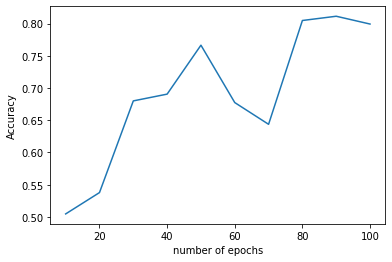

In [ ]:
epochs=[]
acc=[]
for i in range(10,110,10):
    print(i)
    epochs.append(i)
    model = MLP()
    model.fit(train_data, epochs=i, mini_batch_size=800, learning_rate=0.003)
    pred=model.predict(test_data)
    accuracy=evaluate_acc(pred, test_data)
    acc.append(accuracy)
    print(accuracy)
plt.plot(epochs,acc, label='accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')

Experiment #1 (an MLP with a single hidden layer having 128 units and ReLU activations）

In [ ]:
model = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=1, hidden_units_list=[128])
model.fit(train_data, epochs=950, mini_batch_size=750, learning_rate=0.009)
pred=model.predict(test_data)
accuracy=evaluate_acc(pred, test_data)
print(f"The test accuracy for an MLP with one hidden layers is :{accuracy}")

The test accuracy for an MLP with one hidden layers is :0.8677


0.001
0.3642
0.003
0.2808
0.005
0.4649
0.007
0.4891
0.009
0.6014
0.01
0.5743
0.02
0.5932


Text(0, 0.5, 'Accuracy')

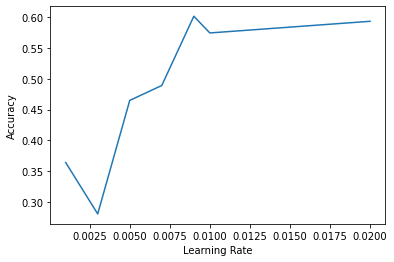

In [ ]:
#find best learning rate
import matplotlib.pyplot as plt
learning_rate=[0.001,0.003,0.005,0.007,0.009,0.01,0.02,0.03,0.04,0.05]
acc=[]
for i in learning_rate:
    print(i)
    model = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=1, hidden_units_list=[128])
    model.fit(train_data, epochs=10, mini_batch_size=1000, learning_rate=i)
    pred=model.predict(test_data)
    accuracy=evaluate_acc(pred, test_data)
    acc.append(accuracy)
    print(accuracy)
plt.plot(learning_rate,acc, label='accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

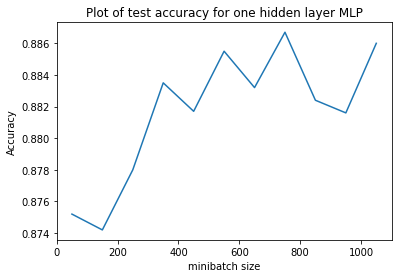

In [ ]:
#find best minibatch_size for one layer MLP
acc=[]
minibatch=[]
for i in range(50,1051,100):
    minibatch.append(i)
    model = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=1, hidden_units_list=[128])
    model.fit(train_data, epochs=550, mini_batch_size=i, learning_rate=0.009)
    pred=model.predict(test_data)
    accuracy=evaluate_acc(pred, test_data)
    acc.append(accuracy)
plt.plot(minibatch,acc, label='accuracy')
plt.title('Plot of test accuracy for one hidden layer MLP')
plt.xlabel('minibatch size')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

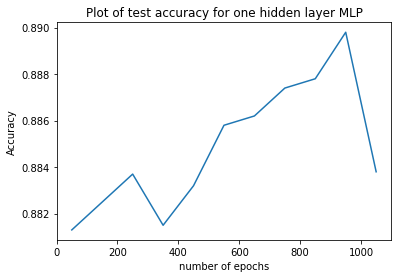

In [ ]:
#find best epochs for one hidden layer MLP
epochs=[]
acc=[]
for i in range(50,1051,100):
    epochs.append(i)
    model = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=1, hidden_units_list=[128])
    model.fit(train_data, epochs=i, mini_batch_size=750, learning_rate=0.009)
    pred=model.predict(test_data)
    accuracy=evaluate_acc(pred, test_data)
    acc.append(accuracy)
plt.plot(epochs,acc, label='accuracy')
plt.title('Plot of test accuracy for one hidden layer MLP')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')

Experiment #1 (an MLP with 2 hidden layers each having 128 units with ReLU activations)

In [ ]:
model = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=2, hidden_units_list=[128,128])
model.fit(train_data, epochs=550, mini_batch_size=950, learning_rate=0.03)
pred=model.predict(test_data)
accuracy=evaluate_acc(pred, test_data)
print(f"The test accuracy for an MLP with two hidden layers is :{accuracy}")

The test accuracy for an MLP with two hidden layers is :0.8794


Text(0, 0.5, 'Test Accuracy')

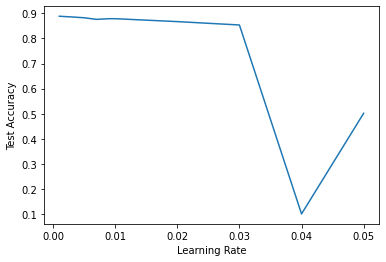

In [ ]:
#find best learning rate
import matplotlib.pyplot as plt
learning_rate=[0.001,0.003,0.005,0.007,0.009,0.01,0.02,0.03,0.04,0.05]
acc=[]
for i in learning_rate:
    model = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=2, hidden_units_list=[128,128])
    model.fit(train_data, epochs=550, mini_batch_size=950, learning_rate=i)
    pred=model.predict(test_data)
    accuracy=evaluate_acc(pred, test_data)
    acc.append(accuracy)
plt.plot(learning_rate,acc)
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')

Text(0, 0.5, 'Test Accuracy')

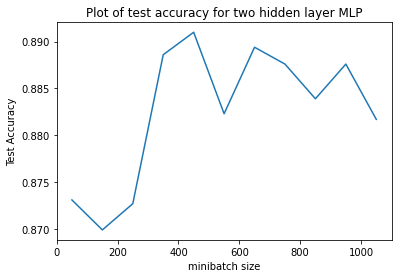

In [ ]:
#find best minibatch_size for two hidden layer MLP
acc=[]
minibatch=[]
for i in range(50,1051,100):
    minibatch.append(i)
    model = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=2, hidden_units_list=[128,128])
    model.fit(train_data, epochs=10, mini_batch_size=i, learning_rate=0.03)
    pred=model.predict(test_data)
    accuracy=evaluate_acc(pred, test_data)
    acc.append(accuracy)
plt.plot(minibatch,acc)
plt.title('Plot of test accuracy for two hidden layer MLP')
plt.xlabel('minibatch size')
plt.ylabel('Test Accuracy')

Text(0, 0.5, 'Test Accuracy')

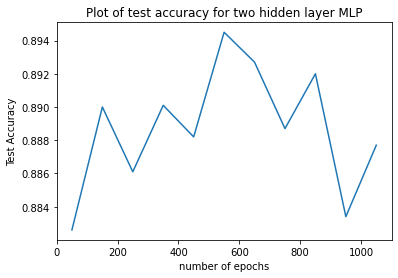

In [ ]:
#find best epochs for two hidden layer MLP
epochs=[]
acc=[]
for i in range(50,1051,100):
    epochs.append(i)
    model = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=2, hidden_units_list=[128,128])
    model.fit(train_data, epochs=i, mini_batch_size=950, learning_rate=0.03)
    pred=model.predict(test_data)
    accuracy=evaluate_acc(pred, test_data)
    acc.append(accuracy)
plt.plot(epochs,acc)
plt.title('Plot of test accuracy for two hidden layer MLP')
plt.xlabel('number of epochs')
plt.ylabel('Test Accuracy')

# Experiment 2: model with 2 hidden layers, in which the activations are now tanh and Leaky-ReLU

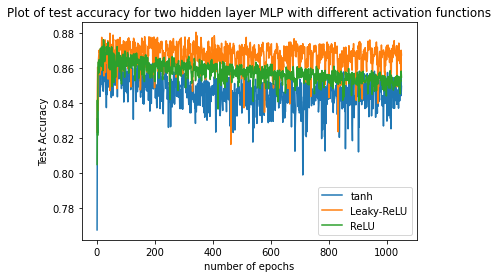

In [ ]:
epochs=[]
acc=[]
acc1=[]
acc2=[]
for i in range(50,1051,100):
    epochs.append(i)
    model = MLP(function=tanh(), function_prime=tanh_prime(),num_hidden_layers=2, hidden_units_list=[128,128])
    model.fit(train_data, epochs=i, mini_batch_size=950, learning_rate=0.03)
    pred=model.predict(test_data)
    accuracy=evaluate_acc(pred, test_data)
    acc.append(accuracy)
    model1 = MLP(function=Leaky_ReLU(),function_prime=Leaky_ReLU_prime(), num_hidden_layers=2, hidden_units_list=[128,128])
    model1.fit(train_data, epochs=i, mini_batch_size=950, learning_rate=0.03)
    pred=model1.predict(test_data)
    accuracy1=evaluate_acc(pred, test_data)
    acc1.append(accuracy1)
    model2 = MLP(function=ReLU(),function_prime=ReLU_prime(), num_hidden_layers=2, hidden_units_list=[128,128])
    model2.fit(train_data, epochs=i, mini_batch_size=950, learning_rate=0.03)
    pred=model2.predict(test_data)
    accuracy2=evaluate_acc(pred, test_data)
    acc2.append(accuracy2)
plt.plot(epochs,acc, label='tanh')
plt.plot(epochs, acc1, label='Leaky-ReLU')
plt.plot(epochs, acc2, label='ReLU')
plt.title('Plot of test accuracy for two hidden layer MLP with different activation functions')
plt.xlabel('number of epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

# Experiment 3: model with 2 hidden layers, activations ReLU, add dropout regularization 

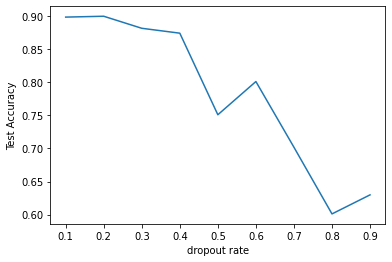

In [ ]:
dropout=[]
acc=[]
for i in range(1,10):
    print(i/10)
    dropout.append(i/10)
    model = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=2, hidden_units_list=[128,128],dropout_rate=i/10)
    model.fit(train_data, epochs=550, mini_batch_size=950, learning_rate=0.03)
    pred=model.predict(test_data)
    accuracy=evaluate_acc(pred, test_data)
    acc.append(accuracy)
plt.plot(dropout,acc)
plt.xlabel('dropout rate')
plt.ylabel('Test Accuracy')
plt.show()

# Experiment 4: model with 2 hidden layers, activations ReLu, unnormalized images

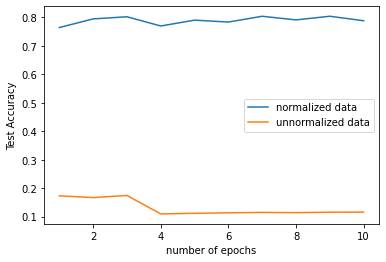

In [ ]:
model = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=2, hidden_units_list=[128,128])
model1 = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=2, hidden_units_list=[128,128])
acc=[]
acc1=[]
epochs=[]
for i in range(1,11):
    epochs.append(i)
    model = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=2, hidden_units_list=[128,128])
    model.fit(unnorm_train_data, epochs=i, mini_batch_size=950, learning_rate=0.03)
    pred=model.predict(unnorm_test_data)
    accuracy=evaluate_acc(pred, train_data)
    acc.append(accuracy)
    model1 = MLP(function=ReLU(), function_prime=ReLU_prime(), num_hidden_layers=2, hidden_units_list=[128,128])
    model1.fit(train_data, epochs=i, mini_batch_size=950, learning_rate=0.03)
    pred1=model1.predict(unnorm_test_data)
    accuracy1=evaluate_acc(pred1, unnorm_train_data)
    acc1.append(accuracy1)
plt.plot(epochs,acc, label='normalized data')
plt.plot(epochs, acc1, label='unnormalized data')
plt.xlabel('number of epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()    

# Experiment 5: convolutional neural network (CNN)

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
def CNN(epochs=1,batch_size=100,learning_rate=1e-3):
    model = models.Sequential()
    #add 2 convolutional layers with ReLU activation function
    #set the input size as (28, 28, 1) since each instance is a 28x28 grayscale image
    model.add(layers.Conv2D(32, kernel_size=2, activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.Conv2D(64, kernel_size=2, activation='relu'))
    #flatten the 3D output to 1D, where fully connected layers take 1D vetor as input
    model.add(layers.Flatten())
    #add 2 fully connected layers each with 128 units, ReLU activation
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    #since we have 10 output class
    model.add(layers.Dense(10))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y))
    return history

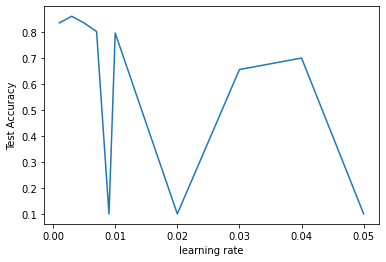

In [ ]:
# find best learning rate for CNN model
learning_rate=[0.001,0.003,0.005,0.007,0.009,0.01,0.02,0.03,0.04,0.05]
acc=[]
for i in learning_rate:
    history=CNN(epochs=1,batch_size=950,learning_rate=i)
    accuracy=history.history['val_accuracy'][0]
    acc.append(accuracy)
plt.plot(learning_rate,acc)
plt.xlabel('learning rate')
plt.ylabel('Test Accuracy')
plt.show()

16
3750/3750 [==============================] - 289s 77ms/step - loss: 0.7230 - accuracy: 0.8404 - val_loss: 0.3814 - val_accuracy: 0.8550
0.8550000190734863
32
1875/1875 [==============================] - 198s 105ms/step - loss: 1.2572 - accuracy: 0.8346 - val_loss: 0.4086 - val_accuracy: 0.8532
0.8532000184059143
64
938/938 [==============================] - 158s 168ms/step - loss: 1.4094 - accuracy: 0.8413 - val_loss: 0.3949 - val_accuracy: 0.8590
0.859000027179718
128
469/469 [==============================] - 160s 339ms/step - loss: 3.3485 - accuracy: 0.8384 - val_loss: 0.3978 - val_accuracy: 0.8589
0.8589000105857849
256
235/235 [==============================] - 132s 559ms/step - loss: 5.7734 - accuracy: 0.8327 - val_loss: 0.3423 - val_accuracy: 0.8773
0.8773000240325928
512
118/118 [==============================] - 120s 1s/step - loss: 13.6428 - accuracy: 0.7941 - val_loss: 0.3716 - val_accuracy: 0.8652
0.8651999831199646
1024
59/59 [==============================] - 120s 2s/s

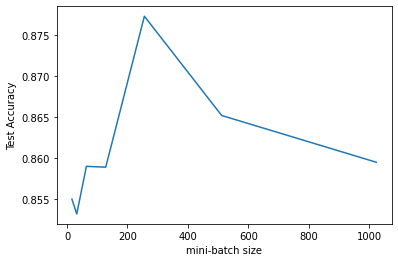

In [ ]:
# find best mini_batch_size for CNN model
acc=[]
minibatch=[]
for i in range(4,11):
    minibatch.append(2**i)
    print(2**i)
    history=CNN(epochs=1,batch_size=2**i,learning_rate=0.003)
    accuracy=history.history['val_accuracy'][0]
    acc.append(accuracy)
    print(accuracy)
plt.plot(minibatch,acc)
plt.xlabel('mini-batch size')
plt.ylabel('Test Accuracy')
plt.show()

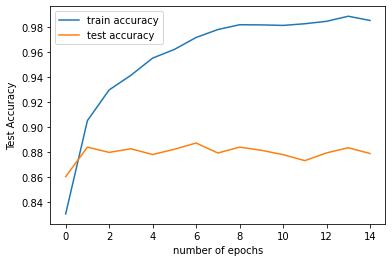

In [ ]:
# find best epoches for CNN model
history=CNN(epochs=15,batch_size=256,learning_rate=0.003)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

# Experiment 6: an MLP architecture that performs as good as possible

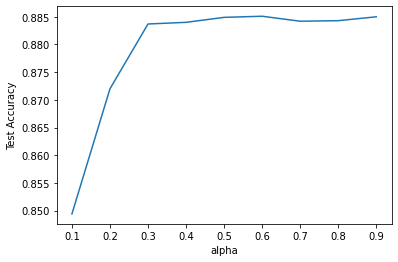

In [ ]:
a_list=[]
acc=[]
for i in range(1,10):
    a_list.append(i/10)
    model = MLP(function=Leaky_ReLU(alpha=i/10),function_prime=Leaky_ReLU_prime(alpha=i/10), num_hidden_layers=2, hidden_units_list=[128,128])
    model.fit(train_data, epochs=550, mini_batch_size=950, learning_rate=0.03)
    pred=model.predict(test_data)
    accuracy=evaluate_acc(pred, test_data)
    acc.append(accuracy)
plt.plot(a_list,acc)
plt.xlabel('alpha')
plt.ylabel('Test Accuracy')
plt.show()